# Milestone 02
# Peter Lorenz

## 0. Preliminaries

Import the required libraries:

In [1]:
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do not truncate numpy arrays
np.set_printoptions(threshold=sys.maxsize)

Declare constants:

In [3]:
CACHE_SIZE=2048

Declare utility functions:

In [103]:
# Search decision tree max_depth
def search_max_depth(value_range, X_train, y_train, class_weight=None):
    # Range of values to test (both methods)
    param_grid = {'max_depth': value_range}

    # Search trees under specified range of values
    tree_dt = GridSearchCV(DecisionTreeClassifier(criterion = 'gini', 
                                                  random_state=0,
                                                  class_weight=class_weight), 
                           param_grid,
                           refit=True)

    # Fit model under optimal parameters
    tree_dt.fit(X_train, y_train)

    # Return optimal max_depth
    return tree_dt.best_params_['max_depth']

# Output key metrics
def display_metrics(y_test, y_pred):
    # Display confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # Display performance metrics
    print(classification_report(y_test, y_pred))

    # Compute ROC metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    # Display ROC plot
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Display ROC score
    print('Area under the ROC curve (AUC):', roc_auc_score(y_test, y_pred))

## 1. Split data from Milestone 1 into training and testing
In this section, we split the prepared data from Milestone 1 into training and test data sets. But first we must reload and clean this data.

### Read and clean data (from Milestone 1)
Here we follow the steps taken in Milestone 1 to prepare our data for modeling. Commentary is kept to a minimum as these matters have already been discussed in Milestone 1. Also, cell output is kept to the minimum necessary to confirm that the code is functioning as expected.

In [5]:
# Internet location of the data set and labels
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

# Download sensor data and labels into a dataframe object, specify python engine for regex
sensor_data = pd.read_csv(url, sep='\s{1,}', engine='python')
sensor_labels_data = pd.read_csv(labels_url, sep='\s{1,}', engine='python')

# Generate index-based column names for the sensor data set
sensor_data.columns = list('s' + str(idx + 1) for idx in range(0, sensor_data.shape[1]))

# Assign column names to the labels
sensor_labels_data.columns = ['result', 'date', 'time']

# Save the original data frame for future reference as we modify its contents
sensor_data_orig = sensor_data

# Confirm that data set and labels are loaded
print('Sensor data set:')
sensor_data.shape
sensor_data.head()

print('Sensor labels:')
sensor_labels_data.shape
sensor_labels_data.head()

Sensor data set:


(1566, 590)

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s581,s582,s583,s584,s585,s586,s587,s588,s589,s590
0,3095.780,2465.140,2230.422,1463.661,0.829,100.000,102.343,0.125,1.497,-0.001,...,0.006,208.204,0.502,0.022,0.005,4.445,0.010,0.020,0.006,208.204
1,2932.610,2559.940,2186.411,1698.017,1.510,100.000,95.488,0.124,1.444,0.004,...,0.015,82.860,0.496,0.016,0.004,3.175,0.058,0.048,0.015,82.860
2,2988.720,2479.900,2199.033,909.793,1.320,100.000,104.237,0.122,1.488,-0.012,...,0.004,73.843,0.499,0.010,0.003,2.054,0.020,0.015,0.004,73.843
3,3032.240,2502.870,2233.367,1326.520,1.533,100.000,100.397,0.123,1.503,-0.003,...,nan,nan,0.480,0.477,0.104,99.303,0.020,0.015,0.004,73.843
4,2946.250,2432.840,2233.367,1326.520,1.533,100.000,100.397,0.123,1.529,0.017,...,0.005,44.008,0.495,0.019,0.004,3.828,0.034,0.015,0.005,44.008


Sensor labels:


(1566, 3)

,result,date,time
0,-1,"""19/07/2008","12:32:00"""
1,1,"""19/07/2008","13:17:00"""
2,-1,"""19/07/2008","14:43:00"""
3,-1,"""19/07/2008","15:22:00"""
4,-1,"""19/07/2008","17:53:00"""


Drop columns with more than 5% NaN:

In [6]:
# Count NaN's per column
df_na = sensor_data.isna().sum()

# Identify columns above cutoff of 5% NaN's
nan_5_pct = df_na[df_na > 0.05 * sensor_data.shape[0]]

# Drop columns with more than 5% NaN's
sensor_data = sensor_data.drop(list(nan_5_pct.index), axis=1)
sensor_data.shape

(1566, 538)

Impute fields with NaN in the remaining columns:

In [7]:
# Impute and replace missing values using column median
sensor_data = sensor_data.replace('?', 
                                  np.NaN).apply(lambda x: x.fillna(x.median()))

Remove columns with zero variance:

In [8]:
# Identify columns with zero variance
zero_variance_cols = np.array(sensor_data.columns[sensor_data.var() == 0])

# Drop columns with zero variance
sensor_data = sensor_data.drop(zero_variance_cols, axis=1)

Remove columns consisting of more than 20% zeros:

In [9]:
# Count zeroes per column
zero_counts = sensor_data[sensor_data == 0].count(axis=0)

# Identify columns above cutoff of 20% zero
zero_20_pct = zero_counts[zero_counts > 0.2 * sensor_data.shape[0]]

# Drop columns with more than 20% zeros
sensor_data = sensor_data.drop(list(zero_20_pct.index), axis=1)
sensor_data.shape

(1566, 401)

Our data set is now almost ready for modeling. We deal with class imbalance and feature standardization after splitting the data into test and training sets.

### Split data into training and test
We now split the data into training and test sets, reserving ten percent of the rows for testing and using the rest to train our models. We choose this relatively high number to ensure that a sufficient number of positives exist in the test data:

In [74]:
# Split data into training and test
X_train, X_test, y_train, y_test = \
    train_test_split(sensor_data, 
                     sensor_labels_data['result'], 
                     test_size = 0.1,
                     random_state = 0)

# Describe training and test
print("Training data has {} rows.".format(X_train.shape[0]))
print("Test data has {} rows.".format(X_test.shape[0]))

Training data has 1409 rows.
Test data has 157 rows.


Now that the test data has been isolated, we can deal with class imbalance and feature standardization in the training data.

### Perform oversampling to balance classes
To address class imbalance we perform oversampling on the training data:

In [75]:
# Instantiate SMOTE reference
sm = SMOTE(random_state=1)

# Apply oversampling to model data and label column
X_resample, y_resample = sm.fit_resample(X_train, y_train)

# Convert resampled model data to dataframe
df_resample = pd.DataFrame(X_resample, columns=X_train.columns)

# Display shape and initial rows
df_resample.shape
df_resample.head()

# Convert labels array to dataframe
df_labels_resample = pd.DataFrame(y_resample, columns=['result'])

(2616, 401)

,s1,s2,s3,s4,s5,s7,s8,s9,s10,s11,...,s577,s578,s583,s584,s585,s586,s587,s588,s589,s590
0,2998.010,2479.770,2189.967,1046.621,0.866,102.362,0.121,1.395,-0.020,0.003,...,1.644,19.784,0.496,0.011,0.003,2.318,0.028,0.008,0.002,27.760
1,3013.320,2538.520,2231.055,1303.539,0.975,95.788,0.120,1.372,0.006,0.001,...,1.544,14.396,0.500,0.014,0.004,2.829,-0.001,0.012,0.004,0.000
2,2940.720,2419.830,2218.055,1517.437,0.858,105.813,0.121,1.460,0.021,-0.002,...,1.845,13.909,0.500,0.027,0.006,5.391,0.006,0.014,0.005,233.244
3,3054.450,2443.680,2243.778,1502.922,1.816,102.098,0.119,1.419,0.002,0.002,...,1.402,9.045,0.497,0.015,0.004,3.070,0.017,0.029,0.009,173.438
4,2821.230,2549.890,2244.111,1676.732,0.920,100.807,0.120,1.484,0.004,-0.002,...,1.398,11.625,0.499,0.018,0.004,3.704,0.013,0.011,0.004,84.434


We confirm that the classes are balanced in the training set:

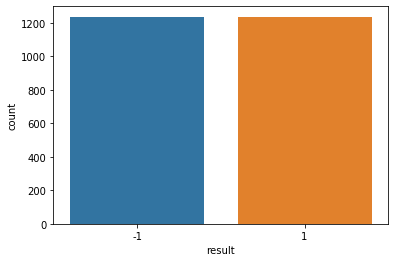

In [69]:
# Display plot of classes in the target variable
sns.countplot(x='result', data=df_labels_resample)

After oversampling, we now have equal numbers of positive and negative outcomes. We are ready to proceed to feature standardization.

### Feature standardization
We choose RobustScaler over StandardScaler due to the skewness of a significant number of features in the data set, as determined in Milestone 1. Because StandardScaler must compute the mean and standard deviation, it is susceptible to outliers. On the other hand, RobustScaler is based on percentiles and, hence, is less susceptible to outliers. We not apply RobustScaler to our training set:

In [76]:
# Scale data
scaler = RobustScaler()
X_resample = pd.DataFrame(scaler.fit_transform(df_resample), 
                          columns=df_resample.columns)

# Display scaled data set
X_resample.head()

,s1,s2,s3,s4,s5,s7,s8,s9,s10,s11,...,s577,s578,s583,s584,s585,s586,s587,s588,s589,s590
0,-0.037,-0.225,-0.255,-0.551,-1.059,0.181,-0.618,-0.824,-1.122,0.148,...,0.025,1.184,-1.119,-0.478,-0.511,-0.460,0.565,-0.818,-0.913,-0.660
1,0.131,0.552,0.941,0.018,-0.796,-1.084,-1.034,-1.099,0.454,0.008,...,-0.193,0.149,-0.214,0.040,0.077,0.050,-1.583,-0.405,-0.364,-1.036
2,-0.665,-1.018,0.563,0.492,-1.079,0.846,-0.701,-0.060,1.404,-0.263,...,0.464,0.055,-0.167,2.587,2.040,2.606,-1.080,-0.167,-0.138,2.125
3,0.582,-0.702,1.311,0.460,1.229,0.130,-1.159,-0.541,0.184,0.046,...,-0.502,-0.880,-0.762,0.279,0.176,0.290,-0.299,1.332,1.444,1.314
4,-1.976,0.703,1.321,0.845,-0.930,-0.118,-0.784,0.218,0.368,-0.272,...,-0.511,-0.384,-0.405,0.915,0.862,0.923,-0.524,-0.446,-0.235,0.108


We now turn to our results from Milestone 1 to select the features for our models.

### Feature selection
In Milestone 1, we applied four different methods to select the best features from our large set of features. Since stepwise (forward) selection produced the features with the most correlation with the other methods, by default we will go with the twenty best features chosen by this method:

1. s22
1. s34
1. s65
1. s104
1. s125
1. s130
1. s144
1. s189
1. s313
1. s438

We select our features determined by stepwise selection here for use below in the models.

In [71]:
# Stepwise-selected features from Milestone 1
stepwise_features = ['s22', 's34', 's65', 's104', 's125', 's130', 's144', 's189', 's313', 's438']

Now that our training data set has been resampled and standardized and we have selected our features, we are ready to proceed to modeling.

## 2. Build decision tree model
In this section, we build a decision tree model to detect faulty products. First we try the set of features chosen by stepwise selection using the gini coefficient. We identify the optimal value for the max_depth hyperparameter, then build a model:

In [106]:
# Search for best hyperparameters
max_depth = search_max_depth(np.arange(3, 12), X_resample[stepwise_features], y_resample)

# Display optimal hyperparameters
print('Optimal max depth: ', max_depth)

Optimal max depth:  10


Using the recommended optimal max_depth of 10, we now build our model and display the confusion matrix, accuracy metrics, and ROC plot:

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

[[ 23 131]
 [  0   3]]
              precision    recall  f1-score   support

          -1       1.00      0.15      0.26       154
           1       0.02      1.00      0.04         3

    accuracy                           0.17       157
   macro avg       0.51      0.57      0.15       157
weighted avg       0.98      0.17      0.26       157



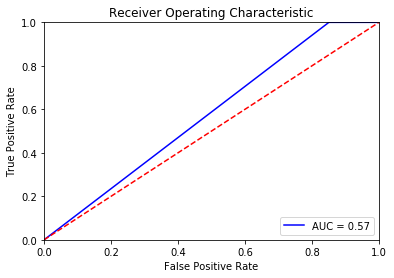

Area under the ROC curve (AUC): 0.5746753246753247


In [107]:
# Construct decision tree classifier
dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = max_depth, 
                                random_state=0)
dt_clf.fit(X_resample[stepwise_features], y_resample)

# Predict based on test data
y_pred_test_dt = dt_clf.predict(X_test[stepwise_features])

# Display metrics
display_metrics(y_test, y_pred_test_dt)

This model has terrible precision because it predicts "negative" outcomes most of the time:

In [39]:
y_pred

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64)

So our model makes rather poor predictions. The recall is 1, but at the expense of precision, which is a measely 0.02, producing an AUC of just 0.57.

Our decision tree seems the wrong way to go, especially given the continuous nature of the data set. We need to consider that decision trees are designed to handle categorical rather than continuous data. Perhaps we can do better with another approach.

## 3. Build ensemble model
In this section, we build an ensemble model to detect faulty products using a random forest to reduce the possibility of overfitting. We begin by finding the optimal values of the n_estimators and max_depth hyperparameters for our random forest:

In [23]:
# Range of values to test (both methods)
param_grid = { 'n_estimators': np.arange(20, 100, 20),
               'max_depth': np.arange(4, 12, 4)}

# Search trees under specified range of values
gs = GridSearchCV(RandomForestClassifier(verbose=0, random_state=1), 
                  param_grid)

# Fit model under optimal parameters
gs.fit(X_resample[stepwise_features], y_resample)
gs_pred = gs.predict(X_test[stepwise_features])
gs_perf = roc_auc_score(y_test, gs_pred)

# Display optimal parameters
print('Optimal number of estimators: ', gs.best_params_['n_estimators'])
print('Optimal max depth: ', gs.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                

Optimal number of estimators:  80
Optimal max depth:  8


Our search of hyperparameter values identified 80 as the optimal value for the n_estimators and 8 as the optimal max_depth. Now we build a random forest model using the subset of ten features chosen by forward selection (Milestone 1):

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

[0.085 0.139 0.086 0.176 0.109 0.1   0.098 0.094 0.062 0.051]
[[10 88]
 [ 0  3]]
              precision    recall  f1-score   support

          -1       1.00      0.10      0.19        98
           1       0.03      1.00      0.06         3

    accuracy                           0.13       101
   macro avg       0.52      0.55      0.12       101
weighted avg       0.97      0.13      0.18       101



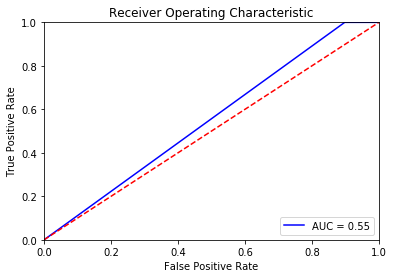

Area under the ROC curve (AUC): 0.5510204081632653


In [24]:
# Build random forest model
clf = RandomForestClassifier(n_estimators=80, max_depth=8, random_state=1, verbose=0)
clf.fit(X_resample[stepwise_features], y_resample)

# Generate predictions
pred_rf = clf.predict(X_test[stepwise_features])

# Display feature importance per feature
print(clf.feature_importances_)

# Display metrics
display_metrics(y_test, pred_rf)

The performance is not great with far too many false positives and, hence, a woeful precision score of just 0.03. So we turn to gradient boosting as a way to improve our model. We start by identifying optimal hyperparameters:

In [25]:
# WARNING: takes a few minutes to run!
# Range of values to test (both methods)
param_grid = { 'n_estimators': np.arange(10, 100, 10),
               'learning_rate': np.arange(0.05, 0.1, 0.05), 
               'max_depth': np.arange(4, 12, 2)}

# Search trees under specified range of values
gs = GridSearchCV(GradientBoostingClassifier(loss='deviance', verbose=0, random_state=0), 
                  param_grid)

# Fit model under optimal parameters
gs.fit(X_resample[stepwise_features], y_resample)
gs_pred = gs.predict(X_test[stepwise_features])
gs_perf = roc_auc_score(y_test, gs_pred)

# Display optimal parameters
print('Optimal number of estimators: ', gs.best_params_['n_estimators'])
print('Optimal learning rate (shrinkage): ', gs.best_params_['learning_rate'])
print('Optimal max depth: ', gs.best_params_['max_depth'])

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...,
                

Optimal number of estimators:  90
Optimal learning rate (shrinkage):  0.05
Optimal max depth:  10


Our search of hyperparameter values identified 90 as the optimal value for n_estimators, 0.05 as the optimal shrinkage, and 10 as the optimal max_depth. Now we are ready to build our model using these parameters:

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[0.093 0.118 0.072 0.178 0.101 0.087 0.101 0.099 0.082 0.068]
[[75 23]
 [ 2  1]]
              precision    recall  f1-score   support

          -1       0.97      0.77      0.86        98
           1       0.04      0.33      0.07         3

    accuracy                           0.75       101
   macro avg       0.51      0.55      0.47       101
weighted avg       0.95      0.75      0.83       101



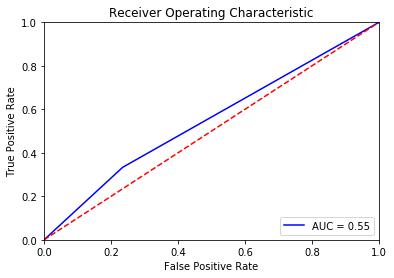

Area under the ROC curve (AUC): 0.5493197278911564


In [26]:
# Construct and fit model using gradient boosting
gbm_clf = GradientBoostingClassifier(n_estimators=90, loss='deviance', 
                                     learning_rate=0.05, max_depth=10)
gbm_clf.fit(X_resample[stepwise_features], y_resample)

# Display feature importances
print(gbm_clf.feature_importances_)

# Generate predictions
pred_gb = gbm_clf.predict(X_test[stepwise_features])

# Display metrics
display_metrics(y_test, pred_gb)

Even with gradient boosting we are not any closer to making quality predictions.

## 4. Build SVM model
In this section, we build an SVM model to detect faulty products. Starting with a linear kernel, we go with the default value of the hyperparameter C (C=1) to avoid overfitting on the training data set. With C=1, we build our model and display the metrics:

SVC(C=1.0, break_ties=True, cache_size=2048, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

[[154   0]
 [  3   0]]
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       154
           1       0.00      0.00      0.00         3

    accuracy                           0.98       157
   macro avg       0.49      0.50      0.50       157
weighted avg       0.96      0.98      0.97       157



C:\Users\Pete\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


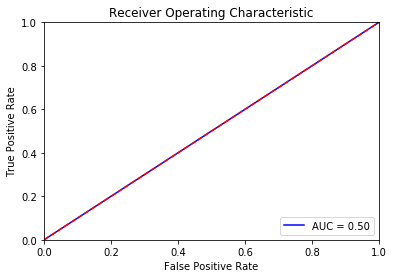

Area under the ROC curve (AUC): 0.5


In [77]:
# Build and fit SVC
svmc = SVC(kernel='linear', cache_size=CACHE_SIZE)
svmc.fit(X_resample[stepwise_features], y_resample)

# Get predictions
y_pred = svmc.predict(X_test[stepwise_features])

# Display metrics
display_metrics(y_test, y_pred)

Our model based on selected features simply predicts that all outcomes are negative:

In [45]:
y_pred

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1], dtype=int64)

Ad hoc experimentation with various values of the hyperparameters *shrinking*, *tol*, and *break_ties* as well as exponentially smaller values of C (more regularization) did not change this result.

The fact that our model is fit to a training data set in which the classes are equal due to oversampling may supply a clue as to the problem. When our model encounters the test data set, in which the classes are extremely inbalanced, it finds essentially a single class of data points (except for the handful of positives). The result seems to be some difficulty in identifying a hyperplane capable of isolating this handful of positives, which in turn interferes with the convergence of the model.

To test out this hunch, we experiment with the *class_weight* hyperparameter and the initial training and test data sets *before oversampling*. We set class_weight='balanced' to allow the model to address the class weights based on the class frequencies in the training data.

SVC(C=0.1, break_ties=False, cache_size=2048, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

[[84 70]
 [ 0  3]]
              precision    recall  f1-score   support

          -1       1.00      0.55      0.71       154
           1       0.04      1.00      0.08         3

    accuracy                           0.55       157
   macro avg       0.52      0.77      0.39       157
weighted avg       0.98      0.55      0.69       157



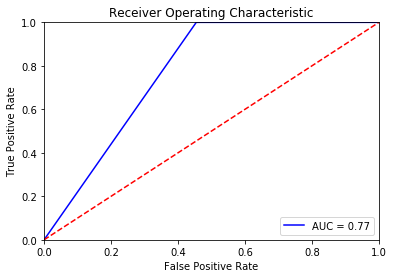

Area under the ROC curve (AUC): 0.7727272727272727


In [116]:
# Build and fit SVC on original training and test sets without oversampling
svmc = SVC(C=0.1, kernel='linear', class_weight='balanced', cache_size=CACHE_SIZE)
svmc.fit(X_train[stepwise_features], y_train)

# Get predictions
y_pred = svmc.predict(X_test[stepwise_features])

# Display metrics
display_metrics(y_test, y_pred)

SVC(C=0.001, break_ties=False, cache_size=2048, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

[[118  36]
 [  1   2]]
              precision    recall  f1-score   support

          -1       0.99      0.77      0.86       154
           1       0.05      0.67      0.10         3

    accuracy                           0.76       157
   macro avg       0.52      0.72      0.48       157
weighted avg       0.97      0.76      0.85       157



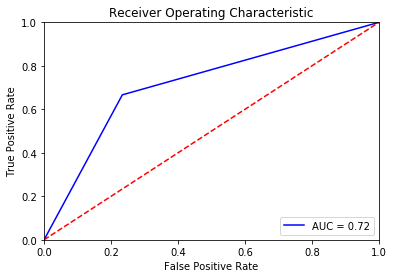

Area under the ROC curve (AUC): 0.7164502164502164


In [115]:
# Build and fit SVC on original training and test sets without oversampling
svmc = SVC(C=0.001, kernel='linear', class_weight='balanced', cache_size=CACHE_SIZE)
svmc.fit(X_train[stepwise_features], y_train)

# Get predictions
y_pred = svmc.predict(X_test[stepwise_features])

# Display metrics
display_metrics(y_test, y_pred)

SVC(C=1e-05, break_ties=False, cache_size=2048, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

[[112  42]
 [  1   2]]
              precision    recall  f1-score   support

          -1       0.99      0.73      0.84       154
           1       0.05      0.67      0.09         3

    accuracy                           0.73       157
   macro avg       0.52      0.70      0.46       157
weighted avg       0.97      0.73      0.82       157



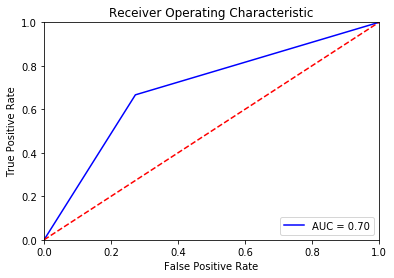

Area under the ROC curve (AUC): 0.696969696969697


In [117]:
# Build and fit SVC on original training and test sets without oversampling
svmc = SVC(C=0.00001, kernel='linear', class_weight='balanced', cache_size=CACHE_SIZE)
svmc.fit(X_train, y_train)

# Get predictions
y_pred = svmc.predict(X_test)

# Display metrics
display_metrics(y_test, y_pred)

## 5. Evaluate all three models
In this section, we evaluate the three models we have created above.

## 6. Conclusion
In this section, we describe our findings.